# HSCT survival: XGBoost model

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

import configuration as config
import functions.helper as helper_funcs
import functions.plotting as plot_funcs

notebook_num='03.2'

# Data files
datasets_file=f'{config.PROCESSED_DATA}/02.1-dataset_definitions.pkl'

# Model files
tuned_model_file=f'{config.MODELS_PATH}/03.2-XGBoost_tuned.pkl'

# Experiment results
hyperparameter_tuning_results=f'{config.DATA_PATH}/results/data/{notebook_num}-hyperparameter_tuning_results.csv'
training_scores_file=f'{config.DATA_PATH}/results/data/{notebook_num}-training_scores.csv'
testing_scores_file=f'{config.DATA_PATH}/results/data/{notebook_num}-testing_scores.csv'

retune_model=True

## 1. Load data

In [2]:
# Read the dataset metadata
with open(datasets_file, 'rb') as input_file:
    datasets=pickle.load(input_file)

# Load one of the datasets
with open(datasets['All ordinal encoded, NAN imputed'], 'rb') as input_file:
    data_dict=pickle.load(input_file)

print('Data dictionary contains:\n')
for key, value in data_dict.items():
    print(f' {key}: {type(value)}')

Data dictionary contains:

 Training features: <class 'pandas.core.frame.DataFrame'>
 Training labels: <class 'pandas.core.frame.DataFrame'>
 Training IDs: <class 'list'>
 Training race group: <class 'list'>
 Testing features: <class 'pandas.core.frame.DataFrame'>
 Testing labels: <class 'pandas.core.frame.DataFrame'>
 Testing IDs: <class 'list'>
 Testing race group: <class 'list'>


## 2. Data preparation

In [3]:
training_features_df=data_dict['Training features']
training_labels_df=data_dict['Training labels']
training_labels_df['log_efs_time']=np.log(training_labels_df['efs_time'])
training_labels_df['reciprocal_efs_time']=1/(training_labels_df['efs_time'])
training_labels_df['square_root_efs_time']=training_labels_df['efs_time']**0.5
training_labels_df['polynomial_efs_time']=training_labels_df['efs_time']**2
training_labels_df['power_efs_time']=1.1**training_labels_df['efs_time']
training_race_groups=data_dict['Training race group']
training_ids=data_dict['Training IDs']

testing_features_df=data_dict['Testing features']
testing_labels_df=data_dict['Testing labels']
testing_labels_df['log_efs_time']=np.log(testing_labels_df['efs_time'])
testing_labels_df['reciprocal_efs_time']=1/(testing_labels_df['efs_time'])
testing_labels_df['square_root_efs_time']=testing_labels_df['efs_time']**0.5
testing_labels_df['polynomial_efs_time']=testing_labels_df['efs_time']**2
testing_labels_df['power_efs_time']=1.1**testing_labels_df['efs_time']
testing_race_groups=data_dict['Testing race group']
testing_ids=data_dict['Testing IDs']

## 3. Label transformation testing

Label type: efs_time


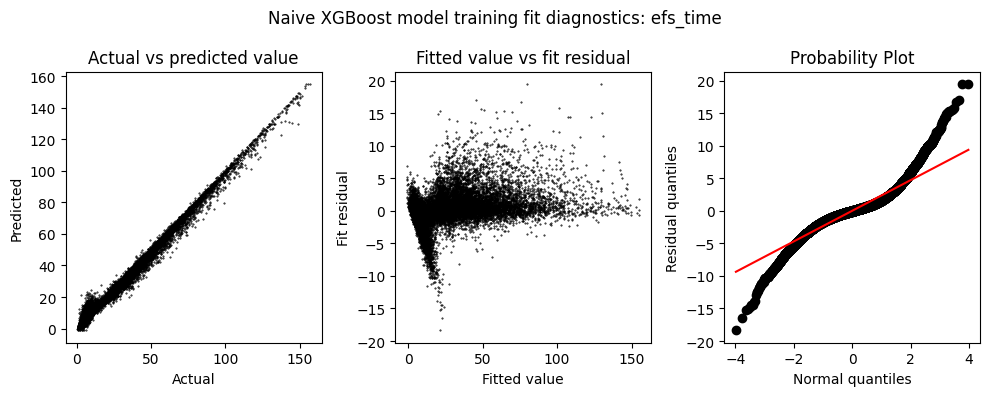

Label type: log_efs_time


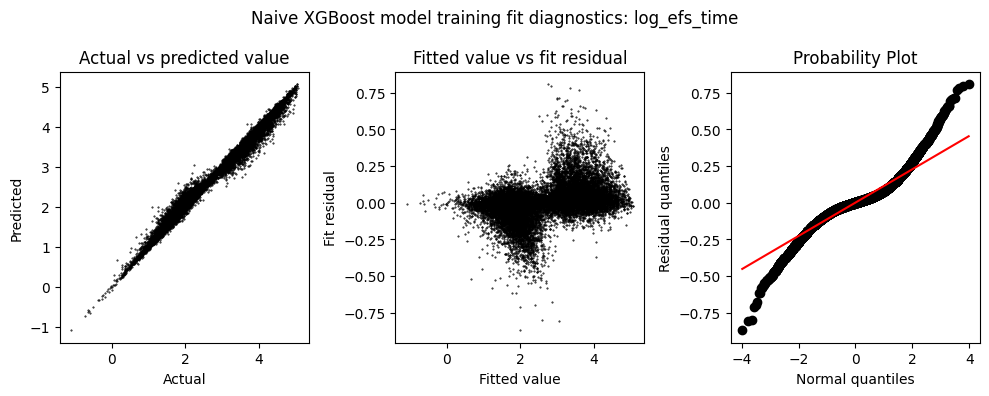

Label type: reciprocal_efs_time


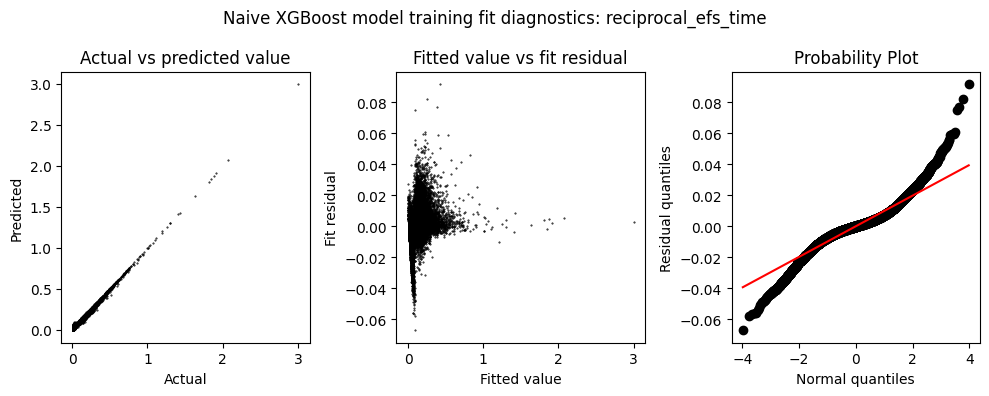

Label type: square_root_efs_time


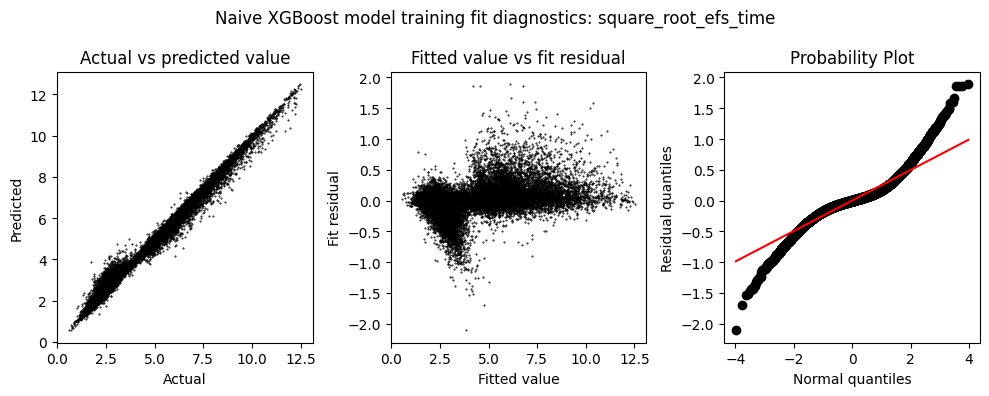

Label type: polynomial_efs_time


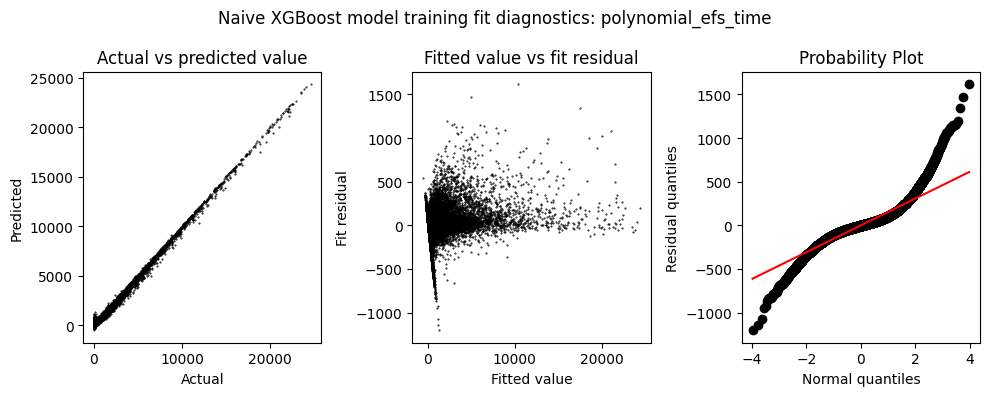

Label type: power_efs_time


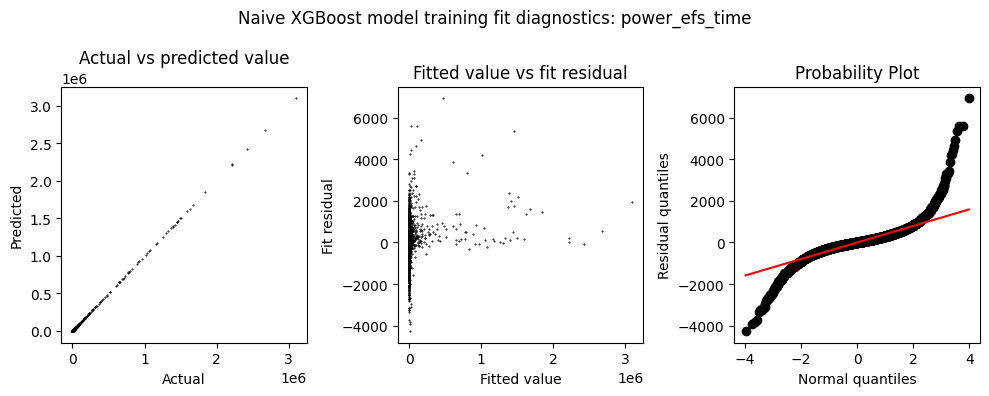

In [4]:
label_types=[
    'efs_time',
    'log_efs_time',
    'reciprocal_efs_time',
    'square_root_efs_time',
    'polynomial_efs_time',
    'power_efs_time'
]

training_score_results={
    'Model': [],
    'RMSE': [],
    'C-index': [],
    'Stratified C-index': []
}

testing_score_results={
    'Model': [],
    'RMSE': [],
    'C-index': [],
    'Stratified C-index': []
}

for label_type in label_types:

    print(f'Label type: {label_type}')

    # XGBoost Model
    xgb_params={
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'seed': 315
    }

    # Train on the complete training set
    dtraining=xgb.DMatrix(
        training_features_df,
        label=training_labels_df[label_type]
    )

    naive_model=xgb.train(
        xgb_params,
        dtraining,
        num_boost_round=1000,
        evals=[(dtraining, 'training')],
        early_stopping_rounds=100,
        verbose_eval=0
    )

    # Make predictions for the training set
    training_predictions=naive_model.predict(dtraining)

    # Make predictions for the testing set
    dtesting=xgb.DMatrix(
        testing_features_df, label=testing_labels_df[label_type]
    )

    testing_predictions=naive_model.predict(dtesting)

    # Make fit diagnostic plots
    plot=plot_funcs.prediction_eval_plot(
        f'Naive XGBoost model training fit diagnostics: {label_type}',
        training_predictions,
        training_labels_df[label_type]
    )

    # Save the plot
    plot.savefig(
        f'{config.DATA_PATH}/results/plots/{notebook_num}-fit_diagnostics_naive_xgb_model_{label_type}.jpg',
        dpi=300
    )

    plot.show()

    if label_type=='reciprocal_efs_time':
        training_predictions=-training_predictions
        testing_predictions=-testing_predictions

    # Score the training set predictions for RMSE, C-index and stratified C-index
    training_score_results=helper_funcs.score_predictions(
        f'Naive: {label_type}',
        training_predictions,
        training_labels_df['efs_time'].values,
        training_labels_df['efs'].values,
        training_race_groups,
        training_ids,
        results=training_score_results
    )

    # Score the testing set predictions for RMSE, C-index and stratified C-index
    testing_score_results=helper_funcs.score_predictions(
        f'Naive: {label_type}',
        testing_predictions,
        testing_labels_df['efs_time'].values,
        testing_labels_df['efs'].values,
        testing_race_groups,
        testing_ids,
        results=testing_score_results
    )

## 4. Hyperparameter tuning

In [5]:
# Manually choose best label transformation based on above plots
label_type='log_efs_time'

# Train or load model as desired
if retune_model == True:

    # Define the hyperparameter search space
    search_space={
        'objective': ['reg:squarederror'],
        'eval_metric': ['rmse'],
        'seed': [315],
        'learning_rate': [0.005],
        'max_depth': [6,8,10],
        #'gamma': [0.01, 0.02, 0.04],
        'subsample': [0.5]
    }

    results_df, tuned_model=helper_funcs.xgb_hyperparameter_search(
        search_space,
        training_features_df,
        training_labels_df[label_type]
    )

    # Save the tuned model
    with open(tuned_model_file, 'wb') as output_file:
        pickle.dump(tuned_model, output_file)

    # Save the hyperparameter tuning results
    results_df.to_csv(hyperparameter_tuning_results)
    
elif retune_model == False:

    # Load the last tuned model
    with open(tuned_model_file, 'rb') as input_file:
        tuned_model=pickle.load(input_file)

    # Load the results from the last tuning run
    results_df=pd.read_csv(hyperparameter_tuning_results)

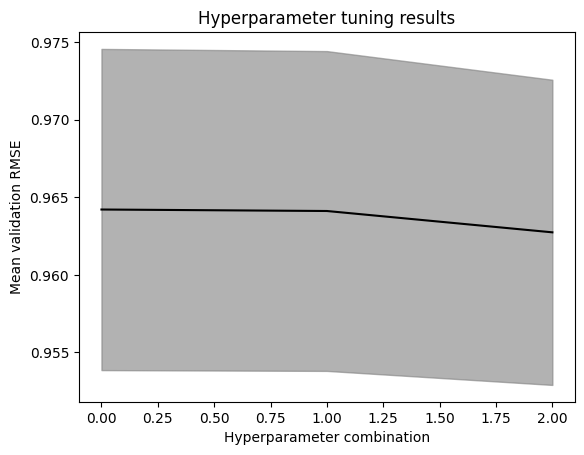

In [6]:
plt.title('Hyperparameter tuning results')
plt.plot(results_df.index, results_df['RMSE mean'], color='black')

plt.fill_between(
    results_df.index,
    results_df['RMSE mean'] - results_df['RMSE standard deviation'],
    results_df['RMSE mean'] + results_df['RMSE standard deviation'],
    color='gray',
    alpha=0.6
)

plt.xlabel('Hyperparameter combination')
plt.ylabel('Mean validation RMSE')
plt.show()

## 5. Evaluate the tuned model

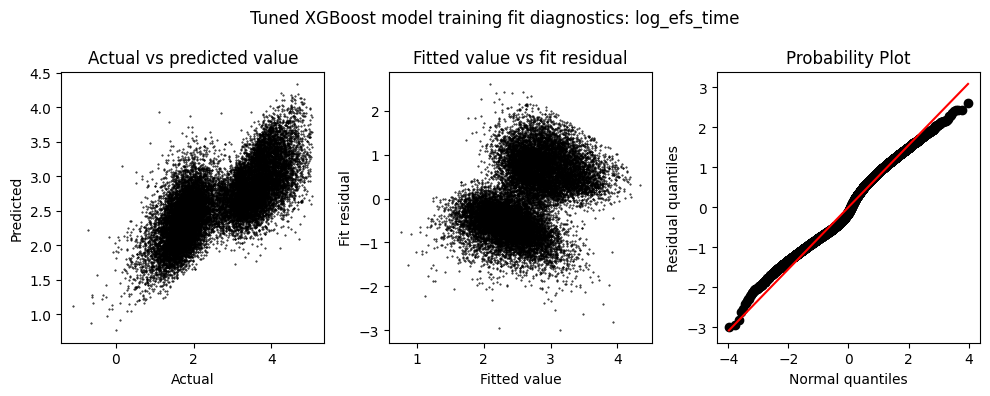

In [7]:
# Make predictions on the training and testing sets
training_predictions=tuned_model.predict(dtraining)
testing_predictions=tuned_model.predict(dtesting)

# Make diagnostic plots for the training set
plot=plot_funcs.prediction_eval_plot(
    f'Tuned XGBoost model training fit diagnostics: {label_type}',
    training_predictions,
    training_labels_df[label_type]
)

# Save the plot
plot.savefig(f'{config.DATA_PATH}/results/plots/{notebook_num}-fit_diagnostics_tuned_xgb_model_{label_type}.jpg', dpi=300)
plot.show()

# Score the training set predictions for RMSE, C-index and stratified C-index
training_score_results=helper_funcs.score_predictions(
    f'Tuned: {label_type}',
    training_predictions,
    training_labels_df['efs_time'].values,
    training_labels_df['efs'].values,
    training_race_groups,
    training_ids,
    results=training_score_results
)

# Score the test set predictions for RMSE, C-index and stratified C-index
testing_score_results=helper_funcs.score_predictions(
    f'Tuned: {label_type}',
    testing_predictions,
    testing_labels_df['efs_time'].values,
    testing_labels_df['efs'].values,
    testing_race_groups,
    testing_ids,
    results=testing_score_results
)

## 6. Model comparison

### 6.1. Training set performance

In [8]:
training_score_results_df=pd.DataFrame.from_dict(training_score_results)
training_score_results_df.to_csv(training_scores_file, index=False)
training_score_results_df.head(len(training_score_results_df))

,Model,RMSE,C-index,Stratified C-index
0,Naive: efs_time,2.468559,0.926914,0.912060
1,Naive: log_efs_time,31.707561,0.971519,0.964209
2,Naive: reciprocal_efs_time,34.149205,0.983286,0.978907
3,Naive: square_root_efs_time,29.711511,0.954749,0.944000
4,Naive: polynomial_efs_time,2596.534171,0.850699,0.833666
5,Naive: power_efs_time,66996.783030,0.571168,0.563135
6,Tuned: log_efs_time,32.155219,0.793300,0.780337


### 6.2. Testing set performance

In [9]:
testing_score_results_df=pd.DataFrame.from_dict(testing_score_results)
testing_score_results_df.to_csv(testing_scores_file, index=False)
testing_score_results_df.head(len(testing_score_results_df))

,Model,RMSE,C-index,Stratified C-index
0,Naive: efs_time,24.336295,0.589136,0.581007
1,Naive: log_efs_time,31.790321,0.624364,0.614051
2,Naive: reciprocal_efs_time,33.749202,0.630547,0.621270
3,Naive: square_root_efs_time,30.552048,0.609579,0.601153
4,Naive: polynomial_efs_time,1931.897129,0.561912,0.554333
5,Naive: power_efs_time,34511.769750,0.514739,0.503724
6,Tuned: log_efs_time,31.819322,0.657337,0.647401
